# 🧠 LSTM Attribution Model (Optimized)

Deep learning model using LSTM to learn attribution from user journey sequences.

**Key Features:**
- Bidirectional LSTM for sequence encoding
- Campaign embeddings
- Mixed precision training for GPU efficiency
- Attention mechanism for interpretable attribution weights

**Optimizations Applied:**
- `cudnn.benchmark=True` for auto-tuned convolutions
- `TensorFloat-32` precision for faster matrix operations
- `batch_size=2048` for better GPU utilization
- Non-blocking data transfers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ========== GPU OPTIMIZATIONS ==========
torch.backends.cudnn.benchmark = True  # Auto-tune convolutions
torch.set_float32_matmul_precision('high')  # Use TensorFloat-32 for faster matmul

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"cuDNN benchmark: {torch.backends.cudnn.benchmark}")

# Paths
DATA_PROCESSED = Path('../data/processed')
RESULTS = Path('../results')
(RESULTS / 'models').mkdir(parents=True, exist_ok=True)
(RESULTS / 'metrics').mkdir(parents=True, exist_ok=True)
(RESULTS / 'figures').mkdir(parents=True, exist_ok=True)

PyTorch: 2.6.0+cu124
Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory: 8.6 GB
cuDNN benchmark: True


## 1. Load Data

In [2]:
with open(DATA_PROCESSED / 'processed_sequences.pkl', 'rb') as f:
    data = pickle.load(f)

train_seq = data['train_sequences']
val_seq = data['val_sequences']
test_seq = data['test_sequences']
config = data['config']

print(f"Train: {len(train_seq):,}")
print(f"Val: {len(val_seq):,}")
print(f"Test: {len(test_seq):,}")
print(f"\nConfig:")
print(json.dumps(config, indent=2, default=str))

Train: 2,631,409
Val: 563,873
Test: 563,874

Config:
{
  "n_campaigns": 676,
  "max_seq_len": 20,
  "sample_rows": 8000000,
  "n_train": 2631409,
  "n_val": 563873,
  "n_test": 563874,
  "conversion_rate": 0.05018546716337391,
  "time_delta_mean": 169292.26415339683,
  "time_delta_std": 214311.97134808675,
  "created_at": "2025-12-15T05:05:43.889145",
  "feature_dim": 4
}


## 2. PyTorch Dataset

In [3]:
class AttributionDataset(Dataset):
    """Dataset for attribution modeling with sequence features."""
    
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {
            'campaigns': torch.LongTensor(seq['campaigns']),
            'clicks': torch.FloatTensor(seq['clicks']),
            'time_deltas': torch.FloatTensor(seq['time_deltas']),
            'mask': torch.FloatTensor(seq['mask']),
            'seq_len': seq['seq_len'],
            'converted': torch.FloatTensor([seq['converted']]),
            'costs': torch.FloatTensor(seq['costs'])
        }

# ========== OPTIMIZED DATALOADER SETTINGS ==========
BATCH_SIZE = 2048  # Increased from 1024 - RTX 4070 8GB handles this with mixed precision

train_loader = DataLoader(
    AttributionDataset(train_seq), 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Windows Jupyter compatibility
    pin_memory=True
)
val_loader = DataLoader(
    AttributionDataset(val_seq),
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    AttributionDataset(test_seq),
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)} (batch_size={BATCH_SIZE})")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1285 (batch_size=2048)
Val batches: 276
Test batches: 276


## 3. LSTM Model with Attention

In [4]:
class LSTMAttributionModel(nn.Module):
    """LSTM-based attribution model with attention mechanism.
    
    The attention weights serve as interpretable attribution scores.
    """
    
    def __init__(self, n_campaigns, embed_dim=64, hidden_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        # Campaign embeddings (0 is padding index)
        self.campaign_embed = nn.Embedding(n_campaigns + 1, embed_dim, padding_idx=0)
        
        # Feature combination: embed + clicks + time_delta
        self.feature_dim = embed_dim + 2
        
        # Bidirectional LSTM encoder
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights for better convergence."""
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, campaigns, clicks, time_deltas, mask=None, return_attention=False):
        batch_size = campaigns.size(0)
        seq_len = campaigns.size(1)
        
        # Embed campaigns
        camp_embed = self.campaign_embed(campaigns)
        
        # Combine features
        features = torch.cat([
            camp_embed,
            clicks.unsqueeze(-1),
            time_deltas.unsqueeze(-1)
        ], dim=-1)
        
        # LSTM encoding
        lstm_out, _ = self.lstm(features)
        
        # Compute attention scores
        attn_scores = self.attention(lstm_out).squeeze(-1)  # (batch, seq_len)
        
        # Apply mask if provided (prevent attention on padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(attn_scores, dim=1)
        
        # Handle NaN from all-padding sequences (rare edge case)
        attn_weights = torch.nan_to_num(attn_weights, nan=0.0)
        
        # Context vector (weighted sum)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        
        # Classify
        logits = self.classifier(context)
        
        if return_attention:
            return logits, attn_weights
        return logits

# Create model
model = LSTMAttributionModel(
    n_campaigns=config['n_campaigns'],
    embed_dim=64,
    hidden_dim=128,
    n_layers=2,
    dropout=0.3
).to(device)

# NOTE: torch.compile() requires Triton which is Linux-only
# On Windows, we skip this optimization

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 672,322
Trainable parameters: 672,322


## 4. Training

In [5]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
scaler = GradScaler()

# Handle class imbalance (adjust pos_weight based on actual conversion rate)
conversion_rate = config.get('conversion_rate', 0.05)
pos_weight = torch.tensor([1.0 / conversion_rate]).clamp(max=10.0).to(device)
print(f"Class imbalance weight: {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training parameters
EPOCHS = 20
best_auc = 0
patience_counter = 0
EARLY_STOP_PATIENCE = 5

history = {'train_loss': [], 'val_auc': [], 'lr': []}

Class imbalance weight: 10.00


In [6]:
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
        
        # Non-blocking transfers for better GPU overlap
        campaigns = batch['campaigns'].to(device, non_blocking=True)
        clicks = batch['clicks'].to(device, non_blocking=True)
        time_deltas = batch['time_deltas'].to(device, non_blocking=True)
        mask = batch['mask'].to(device, non_blocking=True)
        labels = batch['converted'].to(device, non_blocking=True)
        
        with autocast():
            logits = model(campaigns, clicks, time_deltas, mask)
            loss = criterion(logits, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            campaigns = batch['campaigns'].to(device, non_blocking=True)
            clicks = batch['clicks'].to(device, non_blocking=True)
            time_deltas = batch['time_deltas'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            
            logits = model(campaigns, clicks, time_deltas, mask)
            probs = torch.sigmoid(logits)
            
            val_preds.extend(probs.cpu().numpy().flatten())
            val_labels.extend(batch['converted'].numpy().flatten())
    
    val_auc = roc_auc_score(val_labels, val_preds)
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_auc)
    
    # Record history
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_auc'].append(val_auc)
    history['lr'].append(current_lr)
    
    print(f"Epoch {epoch+1}: Loss={train_loss/len(train_loader):.4f}, Val AUC={val_auc:.4f}, LR={current_lr:.6f}")
    
    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'config': config
        }, RESULTS / 'models' / 'lstm_best.pt')
        print(f"  → New best! Saved to lstm_best.pt")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping after {epoch+1} epochs")
            break

print(f"\n✅ Training complete! Best Val AUC: {best_auc:.4f}")

Epoch 1/20: 100%|██████████| 1285/1285 [01:30<00:00, 14.19it/s]


Epoch 1: Loss=0.4945, Val AUC=0.9182, LR=0.001000
  → New best! Saved to lstm_best.pt


Epoch 2/20: 100%|██████████| 1285/1285 [02:47<00:00,  7.66it/s]


Epoch 2: Loss=0.4759, Val AUC=0.9193, LR=0.001000
  → New best! Saved to lstm_best.pt


Epoch 3/20: 100%|██████████| 1285/1285 [03:35<00:00,  5.95it/s]


Epoch 3: Loss=0.4741, Val AUC=0.9193, LR=0.001000
  → New best! Saved to lstm_best.pt


Epoch 4/20: 100%|██████████| 1285/1285 [03:39<00:00,  5.85it/s]


Epoch 4: Loss=0.4733, Val AUC=0.9196, LR=0.001000
  → New best! Saved to lstm_best.pt


Epoch 5/20: 100%|██████████| 1285/1285 [03:41<00:00,  5.81it/s]


Epoch 5: Loss=0.4719, Val AUC=0.9198, LR=0.001000
  → New best! Saved to lstm_best.pt


Epoch 6/20: 100%|██████████| 1285/1285 [03:34<00:00,  5.99it/s]


Epoch 6: Loss=0.4711, Val AUC=0.9196, LR=0.001000


Epoch 7/20: 100%|██████████| 1285/1285 [03:35<00:00,  5.96it/s]


Epoch 7: Loss=0.4704, Val AUC=0.9196, LR=0.001000


Epoch 8/20: 100%|██████████| 1285/1285 [03:42<00:00,  5.78it/s]


Epoch 8: Loss=0.4697, Val AUC=0.9197, LR=0.001000


Epoch 9/20: 100%|██████████| 1285/1285 [03:36<00:00,  5.95it/s]


Epoch 9: Loss=0.4691, Val AUC=0.9198, LR=0.001000
  → New best! Saved to lstm_best.pt


Epoch 10/20: 100%|██████████| 1285/1285 [03:37<00:00,  5.90it/s]


Epoch 10: Loss=0.4665, Val AUC=0.9197, LR=0.000500


Epoch 11/20: 100%|██████████| 1285/1285 [03:36<00:00,  5.94it/s]


Epoch 11: Loss=0.4659, Val AUC=0.9195, LR=0.000500


Epoch 12/20: 100%|██████████| 1285/1285 [03:35<00:00,  5.96it/s]


Epoch 12: Loss=0.4651, Val AUC=0.9194, LR=0.000500


Epoch 13/20: 100%|██████████| 1285/1285 [03:34<00:00,  5.99it/s]


Epoch 13: Loss=0.4646, Val AUC=0.9193, LR=0.000500


Epoch 14/20: 100%|██████████| 1285/1285 [03:36<00:00,  5.93it/s]


Epoch 14: Loss=0.4628, Val AUC=0.9190, LR=0.000250

Early stopping after 14 epochs

✅ Training complete! Best Val AUC: 0.9198


## 5. Training Curves

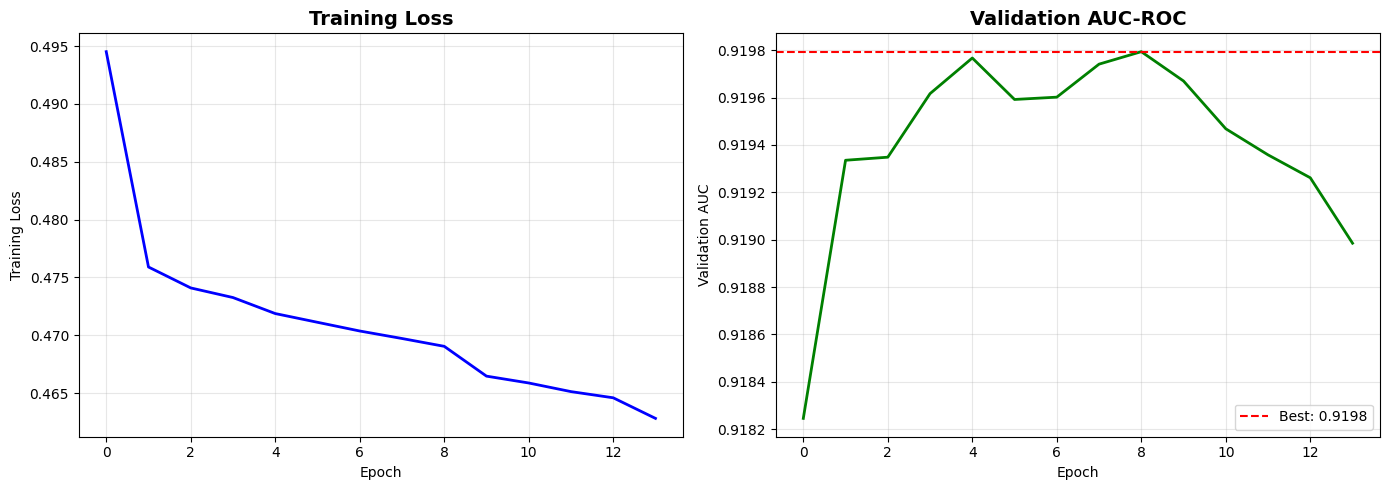

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# AUC curve
axes[1].plot(history['val_auc'], 'g-', linewidth=2)
axes[1].axhline(y=best_auc, color='r', linestyle='--', label=f'Best: {best_auc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation AUC')
axes[1].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS / 'figures' / 'lstm_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Test Evaluation & Attribution Extraction

In [8]:
# Load best model
checkpoint = torch.load(RESULTS / 'models' / 'lstm_best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with AUC {checkpoint['val_auc']:.4f}")

# Test evaluation
test_preds, test_labels = [], []
all_attention = []
all_campaigns = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        campaigns = batch['campaigns'].to(device, non_blocking=True)
        clicks = batch['clicks'].to(device, non_blocking=True)
        time_deltas = batch['time_deltas'].to(device, non_blocking=True)
        mask = batch['mask'].to(device, non_blocking=True)
        
        logits, attn = model(campaigns, clicks, time_deltas, mask, return_attention=True)
        probs = torch.sigmoid(logits)
        
        test_preds.extend(probs.cpu().numpy().flatten())
        test_labels.extend(batch['converted'].numpy().flatten())
        all_attention.extend(attn.cpu().numpy())
        all_campaigns.extend(batch['campaigns'].numpy())

test_auc = roc_auc_score(test_labels, test_preds)
print(f"\n📊 Test AUC: {test_auc:.4f}")

# Classification report
test_binary = [1 if p > 0.5 else 0 for p in test_preds]
print("\nClassification Report:")
print(classification_report([int(l) for l in test_labels], test_binary, target_names=['No Conv', 'Conv']))

Loaded best model from epoch 9 with AUC 0.9198


Testing: 100%|██████████| 276/276 [00:53<00:00,  5.16it/s]



📊 Test AUC: 0.9207

Classification Report:
              precision    recall  f1-score   support

     No Conv       0.99      0.86      0.92    535575
        Conv       0.23      0.78      0.36     28299

    accuracy                           0.86    563874
   macro avg       0.61      0.82      0.64    563874
weighted avg       0.95      0.86      0.89    563874



In [9]:
# Save results
lstm_results = {
    'test_auc': test_auc,
    'best_val_auc': best_auc,
    'history': history,
    'predictions': test_preds,
    'labels': test_labels,
    'attention_sample': all_attention[:1000],
    'campaigns_sample': all_campaigns[:1000]
}

with open(RESULTS / 'metrics' / 'lstm_results.pkl', 'wb') as f:
    pickle.dump(lstm_results, f)

print(f"\n✅ LSTM model training complete!")
print(f"   Model saved: {RESULTS / 'models' / 'lstm_best.pt'}")
print(f"   Results saved: {RESULTS / 'metrics' / 'lstm_results.pkl'}")


✅ LSTM model training complete!
   Model saved: ..\results\models\lstm_best.pt
   Results saved: ..\results\metrics\lstm_results.pkl


---
**Next:** [05_attention_model.ipynb](05_attention_model.ipynb) - Attention-based attribution for better interpretability